<a href="https://colab.research.google.com/github/lawgorithm/clusters_and_modes/blob/main/Mode_finding_with_GMMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.signal import find_peaks
from sklearn.mixture import GaussianMixture

In [15]:
def inv_cdf_from_qtiles(x, cdf_grid, qtile_vals, interp_method):
    """
    Calculates the inverse CDF (quantile function) of a distribution
    based on a grid of cumulative probabilities and corresponding quantile
    values.

    Args:
        x:
          A NumPy array of values for which to calculate the ICDF.
        cdf_grid:
          A NumPy array of cumulative probabilities
          (e.g., [0.1, 0.25, 0.5, 0.75, 0.9]).
        qtile_vals:
          A NumPy array of corresponding quantile values for the cumulative
          probabilities.
        interp_method: The interpolation method to use
          ('lin_interp' or 'cubic_spline').

    Returns:
        A NumPy array of ICDF values corresponding to the input `x`.

    This function uses interpolation to approximate the ICDF based on the
    provided grid of cumulative probabilities and quantile values. The
    interpolation method can be either linear interpolation ('lin_interp') or
    cubic spline interpolation ('cubic_spline').
    """
    if interp_method == 'lin_interp':
        return np.interp(
            x,
            xp=cdf_grid,
            fp=qtile_vals,
            left=None,
            right=None,
            period=None
            )
    elif interp_method == 'cubic_spline':
        return interp1d(
            x=cdf_grid,
            y=qtile_vals,
            kind='cubic'
            )(x)
    else:
        raise ValueError('Invalid interp_method')

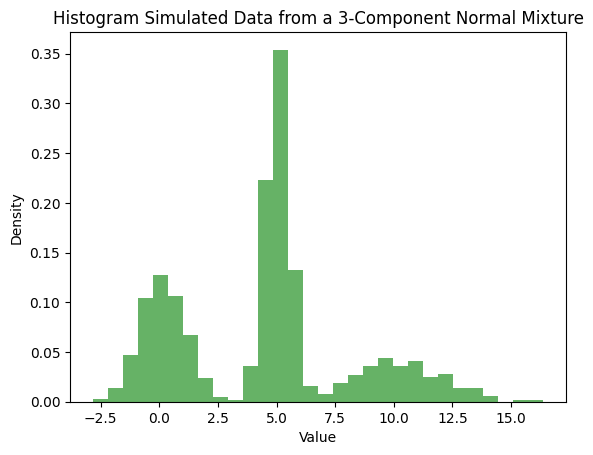

In [16]:
# @title Simluate a 3-component Gaussian Mixture Model

np.random.seed(42)

# Step 1: Define the parameters for the mixture components
MEANS = [0, 5, 10]  # Mean of each component
STD_DEVS = [1, 0.5, 2]  # Standard deviation of each component
PROPORTIONS = [0.3, 0.5, 0.2] # Mixing proportions (must sum to 1)
N_SAMPLES = 1000  # Total number of samples to generate

# Step 2: Sample from a categorical distribution to select the component for
# each sample.
# np.random.choice will give us which component each sample belongs to
component_choices = np.random.choice(
    [0, 1, 2],
    size=N_SAMPLES,
    p=PROPORTIONS)

# Step 3: Generate samples from the corresponding normal distribution
samples = np.zeros(N_SAMPLES)

for i in range(3):
    # Generate samples from the i-th normal distribution
    component_samples = np.random.normal(
        loc=MEANS[i],
        scale=STD_DEVS[i],
        size=np.sum(component_choices == i))
    samples[component_choices == i] = component_samples

# Step 4: Visualize the resulting mixture distribution
plt.hist(samples, bins=30, density=True, alpha=0.6, color='green')
plt.title('Histogram Simulated Data from a 3-Component Normal Mixture')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()


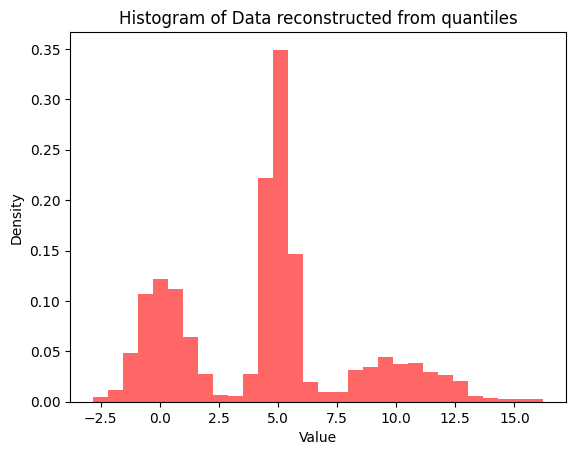

In [17]:
# @title Store the information in the distribution via quantiles (optional)

num_samples = 1e4

# Use the samples to store the information in the distribution as a vector of
# quantiles
cdf_grid = np.linspace(0, 1, num=100)
qtile_vals = np.quantile(samples, cdf_grid)

# Use inverse CDF method to re-generate samples from the stored distribution
random_uniforms = np.random.uniform(0, 1, int(num_samples))
samples_recovered = inv_cdf_from_qtiles(
    random_uniforms, cdf_grid, qtile_vals, interp_method='cubic_spline')

# Re-plot as a sanity check that the method of reducing the data to quantiles
# worked:
plt.hist(samples_recovered, bins=30, density=True, alpha=0.6, color='red')
plt.title('Histogram of Data reconstructed from quantiles')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

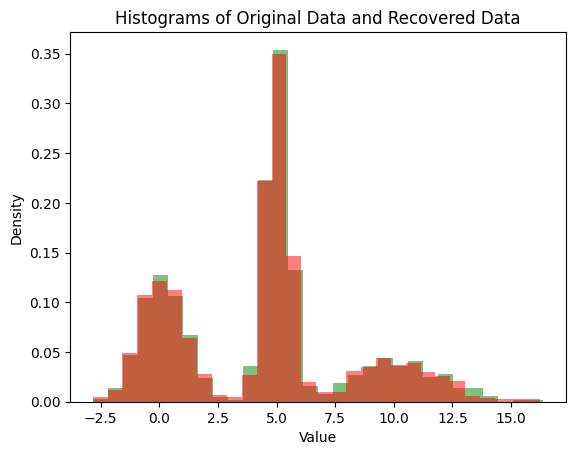

In [18]:
# @title Check the overlay of the two histograms
plt.hist(samples, bins=30, density=True, alpha=0.5, color='green')
plt.hist(samples_recovered, bins=30, density=True, alpha=0.5, color='red')
plt.title('Histograms of Original Data and Recovered Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

# Perform inference to learn the GMM parameters

In [19]:
NUM_MODES = 3

gmm = GaussianMixture(
    n_components=NUM_MODES)
gmm.fit(samples.reshape(-1, 1))

# Access the GMM parameters
weights = gmm.weights_
means = gmm.means_
covariances = gmm.covariances_

# Print the results
print("Weights:", weights)
print("Means:", means)
print("Covariances:", covariances)

Weights: [0.31908929 0.19588856 0.48502216]
Means: [[ 0.13473583]
 [10.32406522]
 [ 5.03333453]]
Covariances: [[[0.89182272]]

 [[3.4214811 ]]

 [[0.26278235]]]


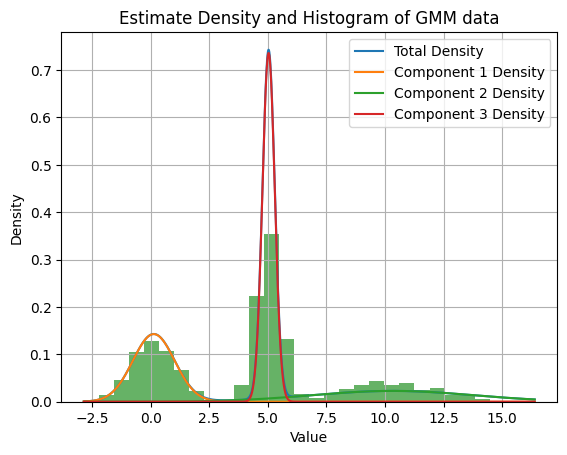

In [20]:
# @title Plot the density defined by the estimate parameters over the histogram

# Define a grid of x values for the x-axis
x = np.linspace(min(samples), max(samples), 1000)

# Loop through each component in the GMM
densities = []
for i in range(NUM_MODES):
  # Extract component weights, means, and covariances
  weight = gmm.weights_[i]
  mean = gmm.means_[i][0]  # Assuming single-dimensional data
  covariance = gmm.covariances_[i][0][0]  # Assuming diagonal covariance

  # Use the PDF function of a normal distribution (adjust for multi-dimensional data)
  density = weight * norm.pdf(x, mean, covariance)
  densities.append(density)

# Plot the total density and individual component densities
plt.plot(x, sum(densities), label='Total Density')
for i, density in enumerate(densities):
  plt.plot(x, density, label=f'Component {i+1} Density')

plt.hist(samples, bins=30, density=True, alpha=0.6, color='green')
plt.title('Estimate Density and Histogram of GMM data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Counting or Inferring the Number of Modes

In [21]:
# @title AIC and BIC, coupled with GMM, for mode counting

data = samples.reshape(-1, 1)

best_aic = float('inf')
best_bic = float('inf')
best_aic_n = 0
best_bic_n = 0
for i in range(1, 5):
  gmm = GaussianMixture(
      n_components=i).fit(
          samples.reshape(-1, 1))
  aic = gmm.aic(data)
  if aic < best_aic:
    best_aic = aic
    best_aic_n = i
  bic = gmm.bic(data)
  if bic < best_bic:
    best_bic = bic
    best_bic_n = i
print(f"AIC favors {best_aic_n}-mode GMM.")
print(f"BIC favors {best_bic_n}-mode GMM.")


AIC favors 3-mode GMM.
BIC favors 3-mode GMM.


In [22]:
# @title Likelihood Ratio Test seems to perform poorly. Probably better to use AIC/BIC or debug this
import scipy.stats

N_COMPS_SIMPLE = 1
N_COMPS_COMPLEX = 3

# Fit GMMs with 1 and 2 components
gmm_simple = GaussianMixture(n_components=N_COMPS_SIMPLE).fit(data)
gmm_complex = GaussianMixture(n_components=N_COMPS_COMPLEX).fit(data)

# Calculate the log-likelihoods
log_likelihood_simple = gmm_simple.score(data)
log_likelihood_complex = gmm_complex.score(data)

# Calculate the test statistic
test_statistic = -2 * (log_likelihood_simple - log_likelihood_complex)

# Calculate the p-value (assuming a chi-squared distribution)

# df is the difference in parameters between the two models. A GMM with k
# components has 3*k parameters (mean, var, weight)
degrees_of_freedom = 3 * (N_COMPS_COMPLEX - N_COMPS_SIMPLE)
p_value = 1 - scipy.stats.chi2.cdf(test_statistic, degrees_of_freedom)

# The null hypthesis is that the smaller model is true
# Compare p-value with significance level
alpha = 0.05
if p_value < alpha:
    print(
        "Reject null: Distribution is likely the more complex model")
else:
    print(
        "Fail to reject null: Distribution is likely the simpler model.")

Fail to reject null: Distribution is likely the simpler model.


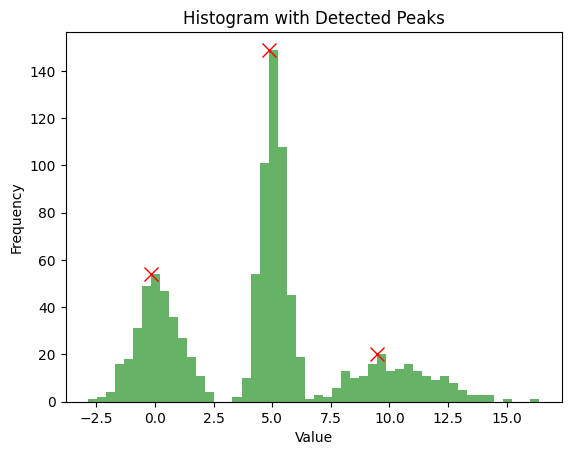

Number of modes: 3


In [23]:
# @title scipy find_peaks heuristics for mode counting

# Create a histogram
hist, bins = np.histogram(samples, bins=50)

# Find peaks in the histogram
peaks, _ = find_peaks(hist, prominence=5)  # Adjust prominence as needed

# Plot the histogram and peaks
plt.hist(samples, bins=bins, color='green', alpha=0.6)
plt.plot(bins[:-1][peaks], hist[peaks], 'x', color='red', markersize=10)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with Detected Peaks')
plt.show()

# Number of modes
num_modes = len(peaks)
print("Number of modes:", num_modes)